In [1]:
import numpy as np
import pImpactR as impact
import matplotlib.pyplot as plt
int = np.vectorize(int)
cmap = plt.get_cmap('rainbow')

In [2]:
NTURN = [128,256]

NL_L = 1.8
NL_c = 0.01
NL_t = 0.4
NL_nu= 0.3034496449165134

ChaosPercent = 99.0

npt_Test = 3834

In [3]:
beam, lattice = impact.readInputFile('../test_IOTA.in')
ke   = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

betx = NL_L/np.sin(2.0*np.pi*NL_nu)
alfx = np.tan(np.pi*NL_nu)

reading ImpactZ input file (../test_IOTA.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
def normalize(data):
    data[:,1] = (data[:,0]*alfx/np.sqrt(betx) + data[:,1]*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx/np.sqrt(betx) + data[:,3]*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    
def unnormalize(data):
    data[:,1] = (-data[:,0]*alfx + data[:,1])*NL_c/np.sqrt(betx)
    data[:,3] = (-data[:,2]*alfx + data[:,3])*NL_c/np.sqrt(betx)
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c

In [5]:
pData = impact.readParticleData(111110,ke,mass,freq,format_id=2,fileLoc='/128/')
pTest = pData[:npt_Test,:]
pData = pData[npt_Test:,:]
normalize(pTest)
normalize(pData)

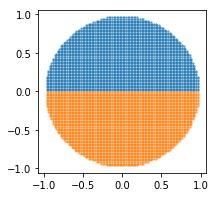

In [6]:
plt.figure(figsize=(3,3))
plt.scatter(pTest[:,0], pTest[:,2],s=2,alpha=0.5)
plt.scatter(pTest[:,0],-pTest[:,2],s=2,alpha=0.5)

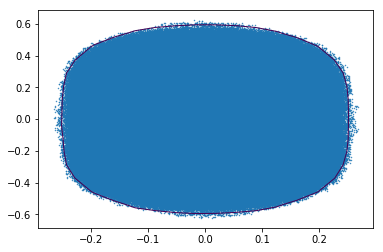

In [7]:
counts,xbins,ybins=np.histogram2d(pData[:,0],pData[:,2],bins=16)

plt.contour(counts.transpose(),
            extent=[np.min(pData[:,0]),np.max(pData[:,0]),np.min(pData[:,2]),np.max(pData[:,2])],
            linewidths=1,linestyles='solid',levels=[1450])
plt.scatter(pData[:,0],pData[:,2],s=0.2)

In [8]:
iTBT = {}
TBT = {}
X = {}
Y = {}
Npt = {}

for nturn in NTURN:
    print(nturn)
    iTBT[nturn],TBT[nturn] = impact.readTBT(nturn,ke,mass,freq,path='./'+str(nturn))
    TBT[nturn] = TBT[nturn][:,:4,:]
    Npt[nturn] = len(iTBT[nturn])
    
for nturn in NTURN:
    print(nturn)
    iTBT[-nturn],TBT[-nturn] = impact.readTBT(100000+nturn,ke,mass,freq,path='./'+str(nturn))
    TBT[-nturn] = TBT[-nturn][:,:4,:]
    Npt[-nturn] = len(iTBT[-nturn])

128
256
128
256


In [9]:
for i in range(len(NTURN)):
    nturn = NTURN[i]
    
    npt = len(iTBT[nturn])
    X[nturn]=np.zeros((nturn,npt),dtype=np.complex)
    Y[nturn]=np.zeros((nturn,npt),dtype=np.complex)
    
    iturn = 0
    for j in range(i+1):
        jturn = NTURN[j]
        
        itmp = np.in1d(iTBT[jturn],iTBT[nturn])
        tmp = TBT[jturn][:,:,itmp]
        X[nturn][iturn:jturn] = (tmp[:,0,:] - 1j*(betx*tmp[:,1,:]+alfx*tmp[:,0,:]))/(NL_c*np.sqrt(betx))
        Y[nturn][iturn:jturn] = (tmp[:,2,:] - 1j*(betx*tmp[:,3,:]+alfx*tmp[:,2,:]))/(NL_c*np.sqrt(betx))
        print(iturn,jturn,nturn,np.sum(itmp),npt)
        
        iturn = jturn
        
        
        
for i in range(len(NTURN)):
    nturn = NTURN[i]
    
    npt = len(iTBT[-nturn])
    X[nturn]=np.zeros((nturn,npt),dtype=np.complex)
    Y[nturn]=np.zeros((nturn,npt),dtype=np.complex)
    tmp = TBT[-nturn][::-1,:4,:]
    X[-nturn]=(tmp[:,0,:] - 1j*(betx*tmp[:,1,:]+alfx*tmp[:,0,:]))/(NL_c*np.sqrt(betx))
    Y[-nturn]=(tmp[:,2,:] - 1j*(betx*tmp[:,3,:]+alfx*tmp[:,2,:]))/(NL_c*np.sqrt(betx))
    
    iturn = 0
    for j in range(i+1):
        jturn = NTURN[j]
        
        itmp = np.in1d(iTBT[jturn],iTBT[-nturn])
        tmp = TBT[jturn][:,:,itmp]
        X[nturn][iturn:jturn] = (tmp[:,0,:] - 1j*(betx*tmp[:,1,:]+alfx*tmp[:,0,:]))/(NL_c*np.sqrt(betx))
        Y[nturn][iturn:jturn] = (tmp[:,2,:] - 1j*(betx*tmp[:,3,:]+alfx*tmp[:,2,:]))/(NL_c*np.sqrt(betx))
        print(iturn,jturn,nturn,np.sum(itmp),npt)
        
        iturn = jturn

0 128 128 3521 3521
0 128 256 3474 3474
128 256 256 3474 3474
0 128 128 3519 3519
0 128 256 3447 3447
128 256 256 3447 3447


In [10]:
nturn = 128
iturn = 126
ipt = 100
print(X[nturn][iturn,ipt]-X[-nturn][iturn,ipt])

(8.076911361953876e-11-2.576328039793907e-11j)


In [11]:
Adiff = {}

for nturn in NTURN:
    nturn = -nturn
    Xdiff = np.abs(X[nturn][0]-X[-nturn][0])**2
    Ydiff = np.abs(Y[nturn][0]-Y[-nturn][0])**2
    Adiff[nturn] = np.sqrt(Xdiff + Ydiff)
    Adiff[nturn] = np.log10(Adiff[nturn])

# Plot

### DA

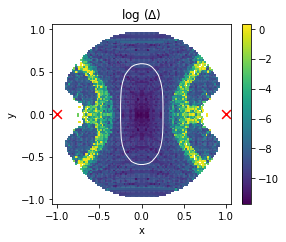

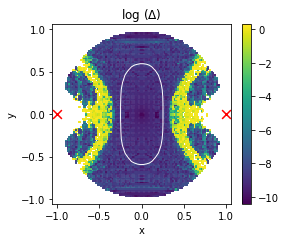

In [12]:
n=128
xmax = np.max([np.real(X[n][0,:]),np.real(Y[n][0,:])])
data={}
for n in NTURN:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Adiff[-n],s=1.6,marker='s')
    plt.scatter(np.real(X[n][0,:]),-np.real(Y[n][0,:]),c=Adiff[-n],s=1.6,marker='s')
    plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.contour(counts.transpose(),
                extent=[np.min(pData[:,0]),np.max(pData[:,0]),np.min(pData[:,2]),np.max(pData[:,2])],
                linewidths=1,colors='white',linestyles='solid',levels=[1450])
    plt.savefig('Next256turns.FB.turn='+str(n)+'.png',dpi=180)
    data['FB.T='+str(n)]={'X':X[n][0,:].real,'Y':Y[n][0,:].real,'c':Adiff[-n]}

In [13]:
import pickle
pickle.dump(data,open('FB.data.pickle','wb'))